# Imports and utility functions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multianndata as md
import vima.data.samples as vds
import vima.data.patchcollection as vdp
import vima.association as va
import vima.training as vt
import vima.vis as vv
from vima.models.resnet_vae import ResnetVAE
import gc, os, cna, torch
import scanpy as sc
torch.set_default_device('mps') # for running on macbook's GPU

vt.seed(0)
os.makedirs(f'./_results', exist_ok=True)

# Load dataset

In [5]:
# read in samples
def fname_parser(fname):
    fname = fname.split('/')[-1].split('.nc')[0]
    return {
        'donor': fname.split('_')[0].replace('Repeat',''),
        'sid': fname
    }
repname = 'pca_k=5_harmony'
samples = vds.read_samples(f'../../RA/BHAM-data/10u/{repname}/*.nc', fname_parser)

# read in and reformat sample metadata
fullmeta = pd.read_csv('../../RA/BHAM-data/ihc-metadata.csv').set_index('subject_id')[['CTAP']]
fullmeta.index = fullmeta.index.str.replace('V0', '')
fullmeta = pd.merge(fullmeta, pd.get_dummies(fullmeta.CTAP.str.replace(' + ', ''), prefix='', prefix_sep=''),
        left_index=True, right_index=True)
fullmeta['fstar'] = fullmeta.F | fullmeta.TF | fullmeta.EFM

100%|███████████████████████████████████████████████████████████████| 27/27 [00:05<00:00,  4.71it/s]


In [7]:
# choose which patches to train on
P = vdp.PatchCollection(samples)
print(len(P), 'patches')

# choose which patches to do case/ctrl analysis on
Pdense = vdp.PatchCollection(samples, max_frac_empty=0.2, sid_nums=P.sid_nums)
print(len(Pdense), 'dense patches')

# change samplemeta so that each row is a sample rather than a donor
inourdata = P.meta[['sid','donor']].drop_duplicates()
samplemeta = pd.merge(inourdata, fullmeta, left_on='donor', right_index=True, how='left').set_index('sid', drop=True)

100%|███████████████████████████████████████████████████████████████| 27/27 [00:06<00:00,  4.00it/s]


in pytorch mode
means: [-0.05243341 -0.03230548 -0.00229284 -0.02602001  0.00177622]
stds: [0.7899571  0.78198457 0.75690424 0.5287932  0.39302906]
data augmentation is off
39302 patches


100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.06it/s]


in pytorch mode
means: [-0.01986702  0.01847242  0.16045238  0.01280834  0.0355637 ]
stds: [1.003124  1.0235384 0.9741713 0.6844343 0.5384007]
data augmentation is off
10345 dense patches


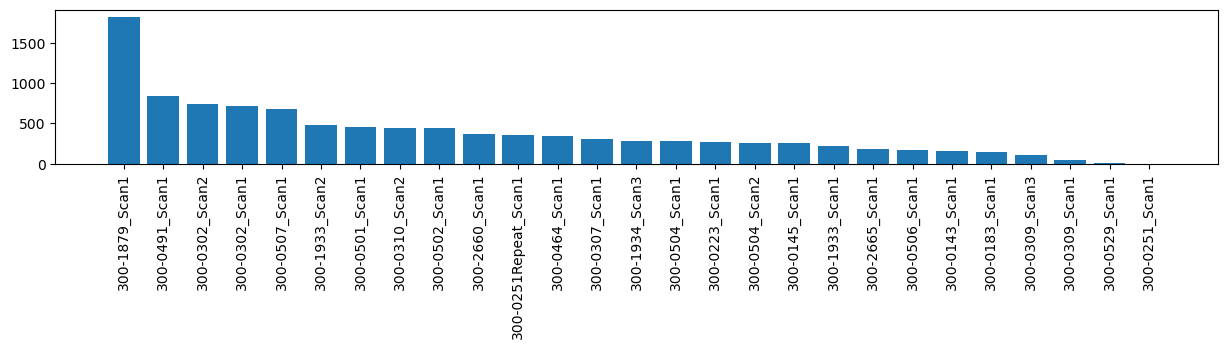

27it [00:05,  5.27it/s]
/Users/yakir/Dropbox/py/tpae/data/samples.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


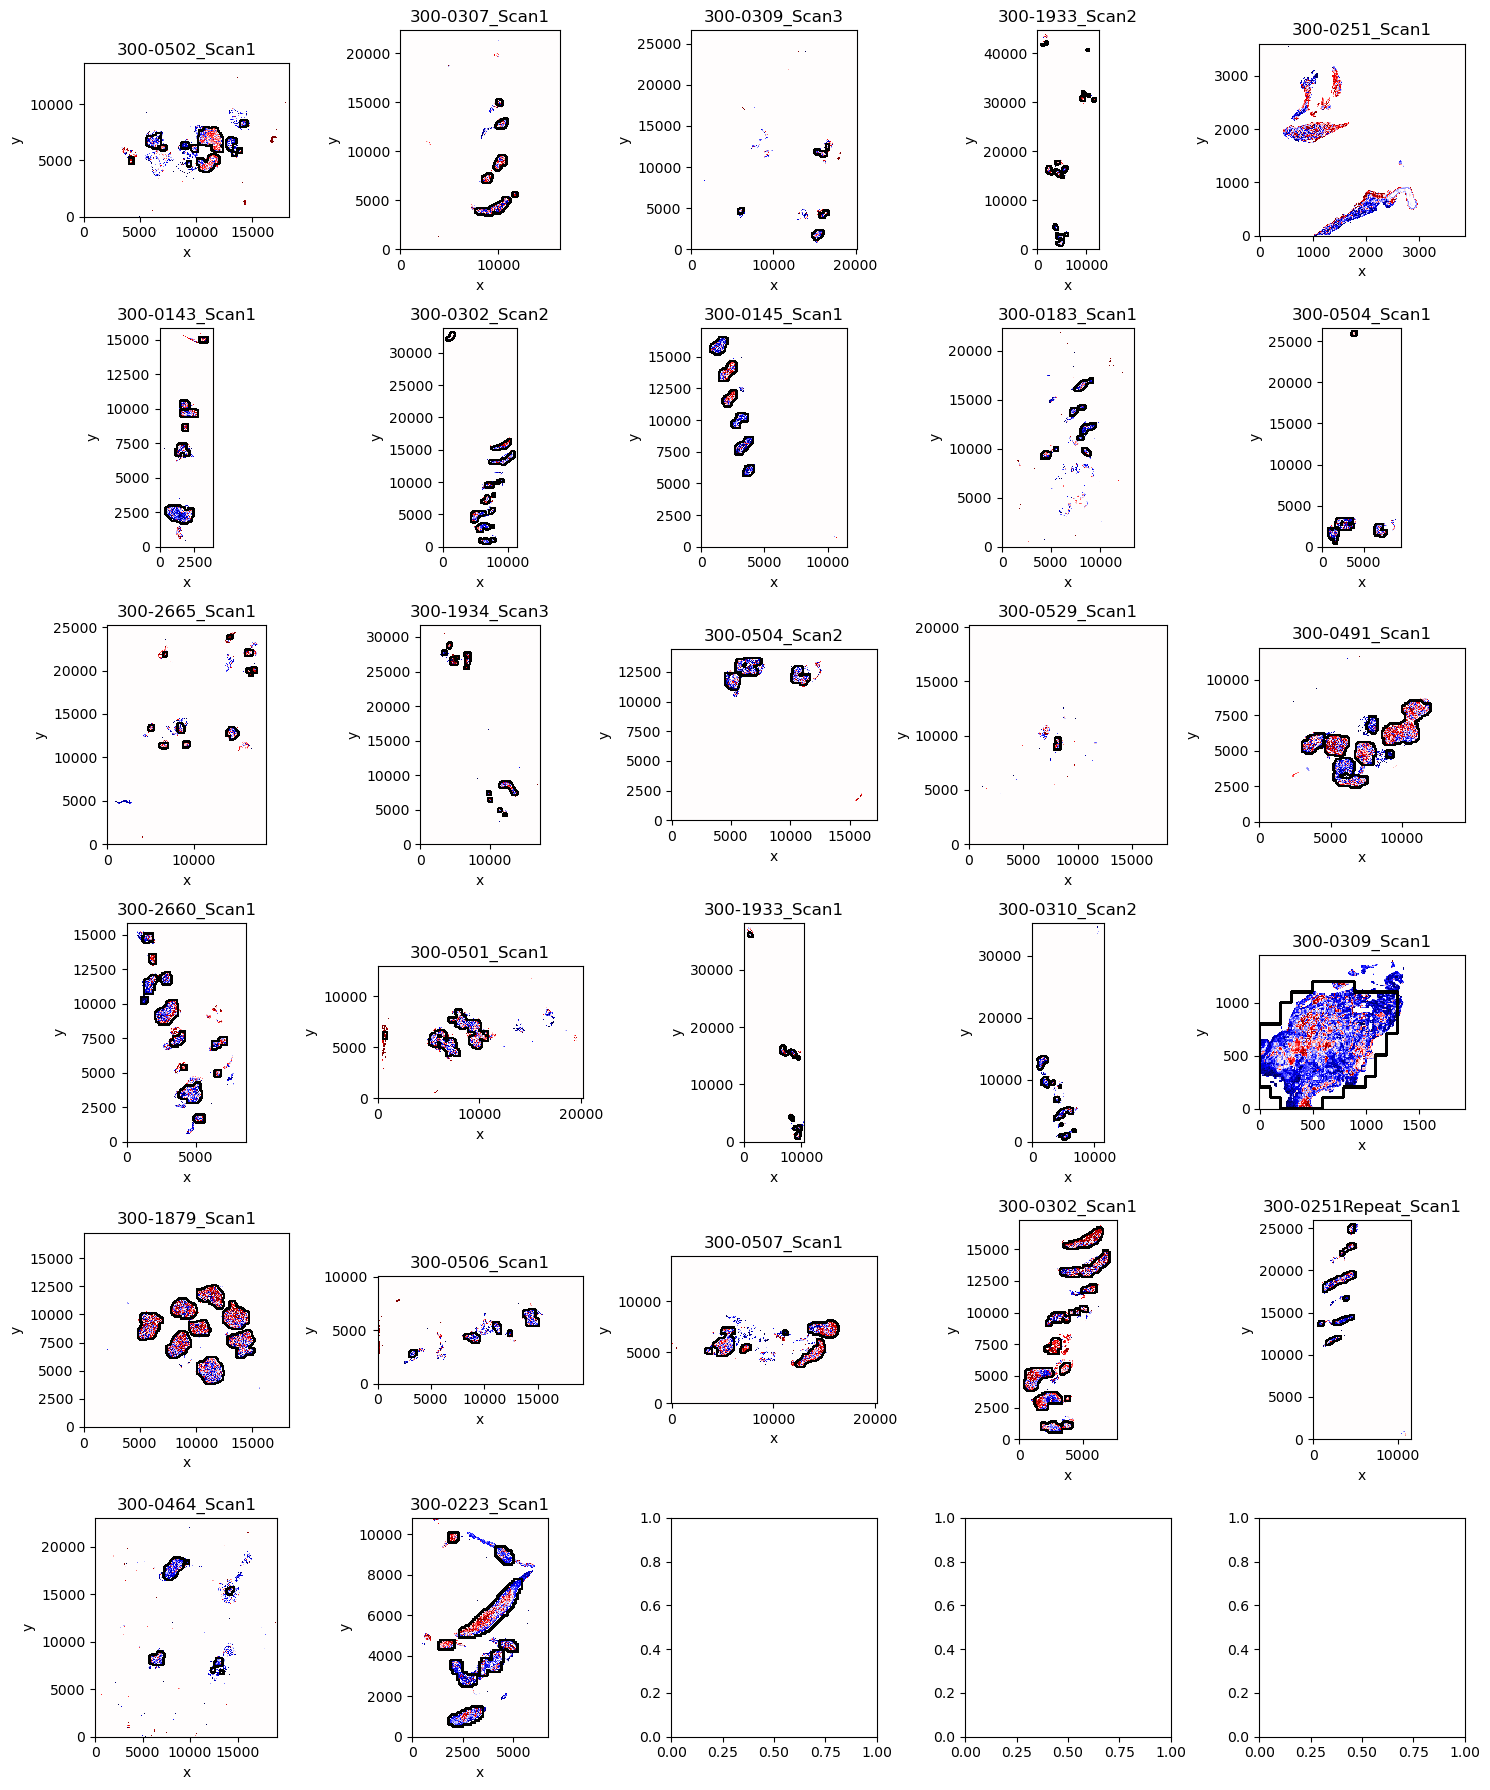

In [172]:
# visualize resulting patches
vds.plot_npatches_per_sample(samples, Pdense.meta)
vds.plot_samples_with_patches(samples.values(), 'hPC1', Pdense.meta, ncols=5, vmin=-2, vmax=2, cmap='seismic')

# Train VAE

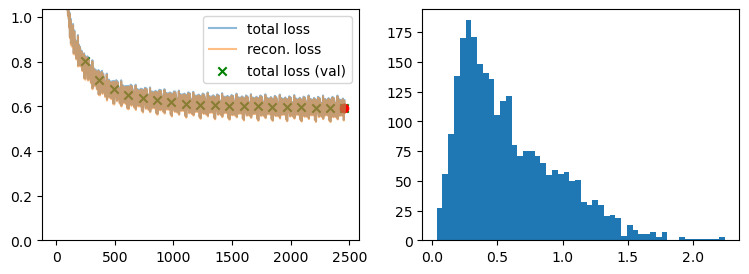

epoch 20. best validation loss = 0.5929325222969055
	total time: 54.52265810966492


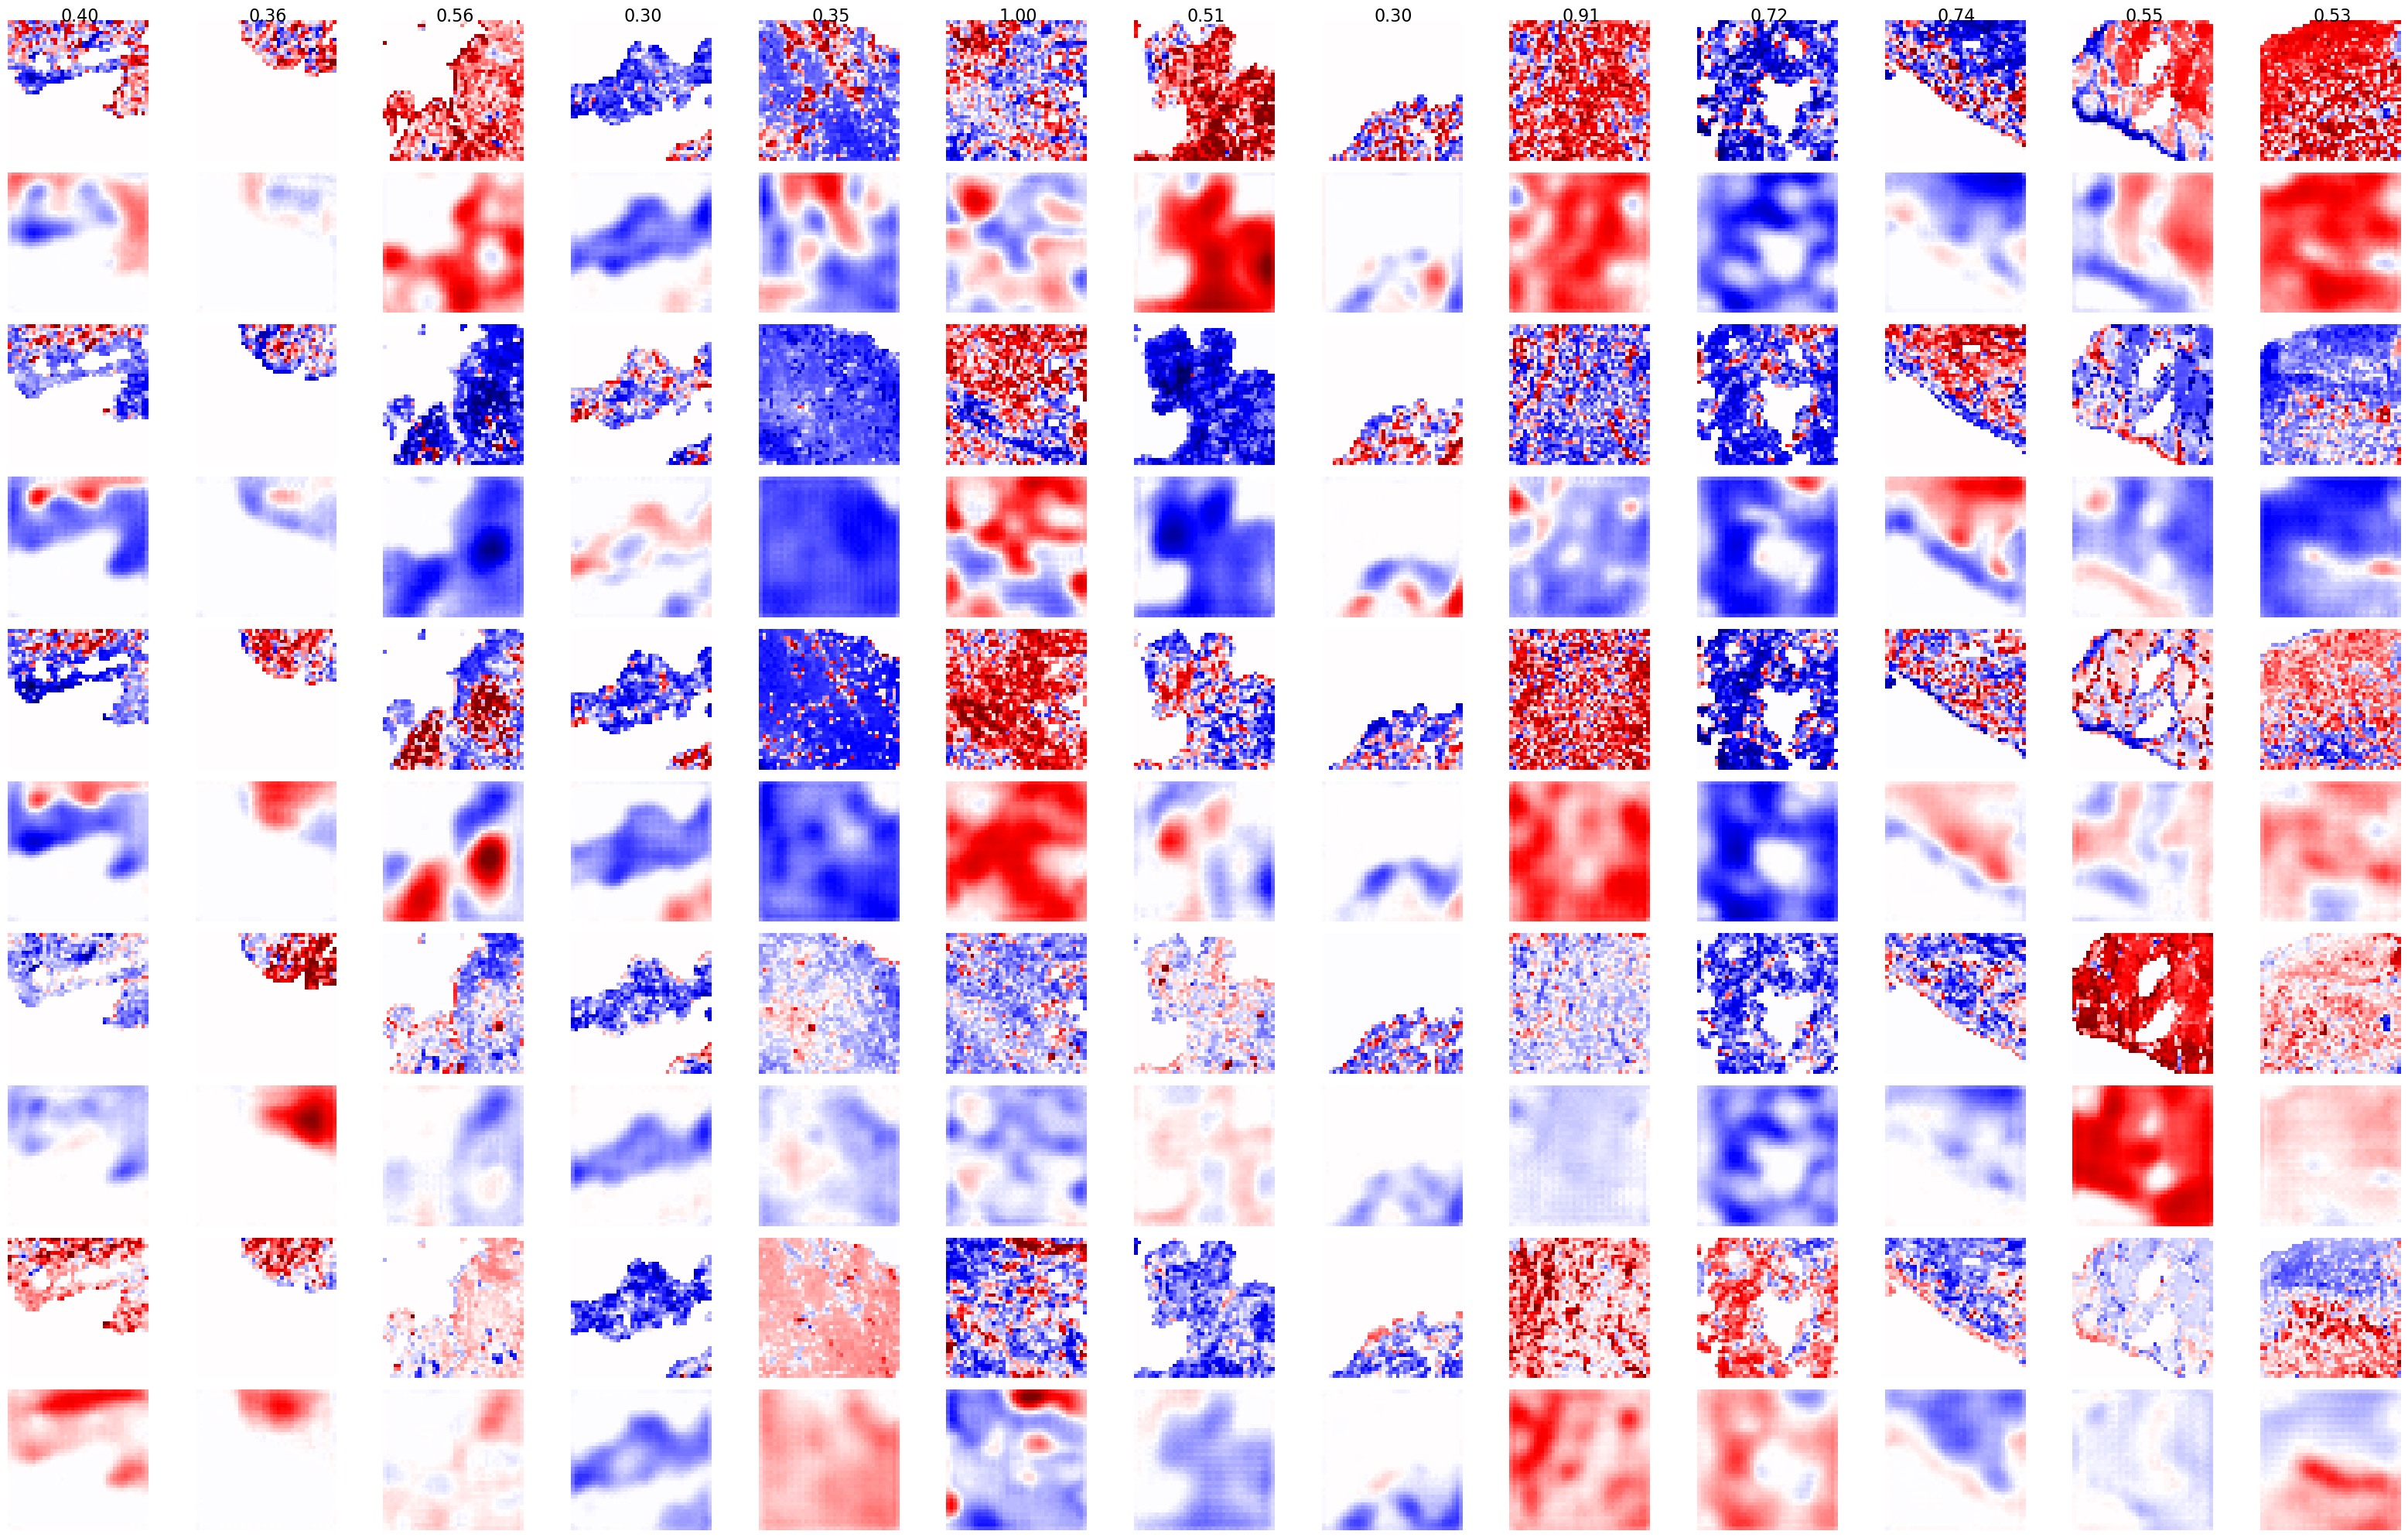

In [7]:
model = ResnetVAE(P.nmarkers, P.nsamples)

model, losslogs = vt.train(model, P)
torch.save(model.state_dict(), f'_results/default-vae.pt')

# Create patch representations

## VAE representation

in pytorch mode
data augmentation is off


100%|███████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.71it/s]


running UMAP


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


built MultiAnnData object with sid as the unit of analysis


/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


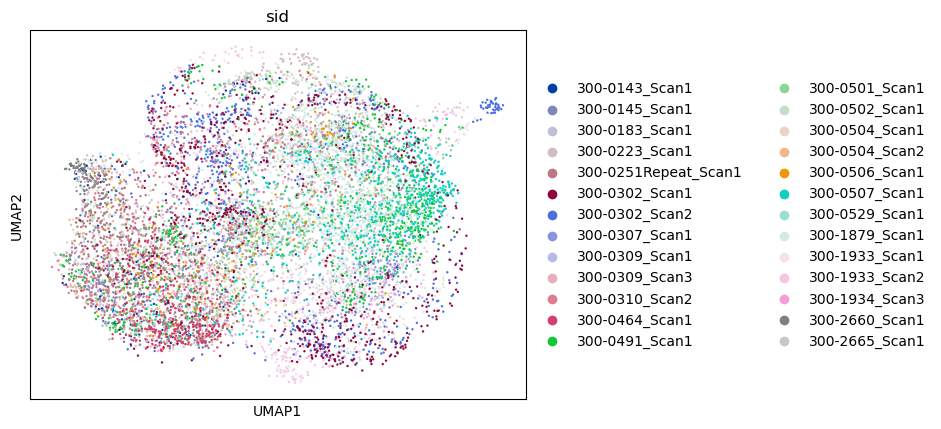

In [8]:
# load model
model = ResnetVAE(P.nmarkers, P.nsamples)
model.load_state_dict(torch.load(f'_results/default-vae.pt'))

# apply model and build umap
Ddense = va.latentrep(model, Pdense, samplemeta)
sc.pl.umap(Ddense, color='sid')
sc.tl.leiden(Ddense)

Ddense.write(f'_results/default-vae.h5ad')

## Patchwide avg representation

data augmentation is off
in numpy mode


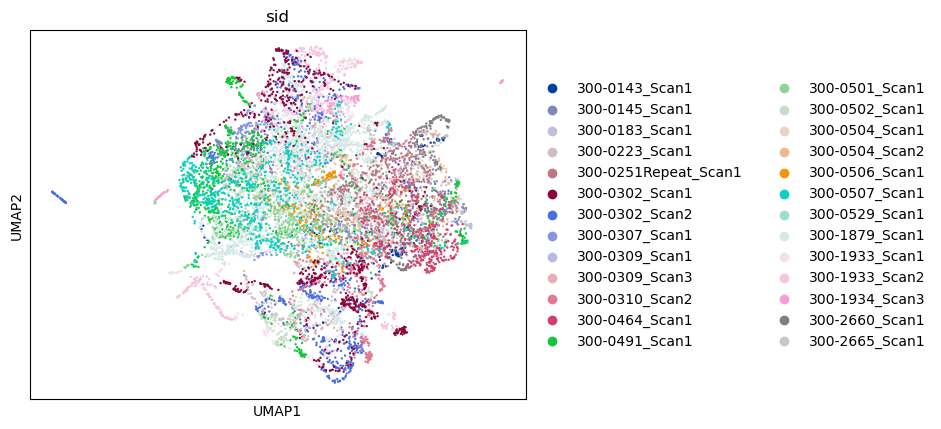

In [205]:
Pdense.numpy_mode()
Ddense_avg = md.MultiAnnData(
    X=Pdense[:][0].mean(axis=(1,2)),
    obs=Ddense.obs)
Ddense_avg.samplem = Ddense.samplem
Ddense_avg.sampleid = 'sid'
sc.pp.neighbors(Ddense_avg, use_rep='X')
sc.tl.umap(Ddense_avg)
sc.tl.leiden(d, resolution=0.2)
Ddense_avg.write(f'_results/patchwideavgs.h5ad')
sc.pl.umap(Ddense_avg, color='sid')

## Patchwide avg representation with non-harmonized pixels

In [3]:
# read in samples
repname = 'normalized'
samples_m = vds.read_samples(f'../../RA/BHAM-data/10u/{repname}/*.nc', fname_parser)

100%|███████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.76it/s]


In [7]:
Mdense = vdp.PatchCollection(Pdense.meta,
                        samples_m, sid_nums=sid_nums, standardize=True)
print(len(Pdense), 'dense patches')

in pytorch mode
means: [ 0.11102158 -0.22448999  0.0453077  -0.01259733  0.08451004  0.1990229
  0.05392234]
stds: [0.9417771 0.8469853 0.8860226 0.9049172 0.9235956 0.9970432 0.9069578]
data augmentation is off
10345 dense patches


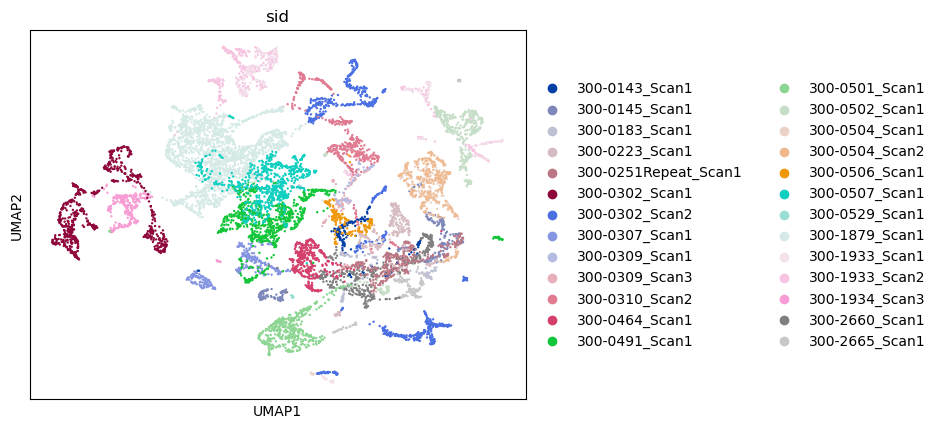

In [11]:
Ddense = cna.read(f'_results/{name}-vae.h5ad'); Ddense.sampleid = 'sid'

Mdense.numpy_mode()
Mdense_avg = md.MultiAnnData(
    X=Mdense[:][0].mean(axis=(1,2)),
    obs=Ddense.obs)
Mdense_avg.samplem = Ddense.samplem
Mdense_avg.sampleid = 'sid'
sc.pp.neighbors(Mdense_avg, use_rep='X')
sc.tl.umap(Mdense_avg)
cna.tl.nam(Mdense_avg, force_recompute=True)
Mdense_avg.write(f'_results/patchwideavgs_nonharmpixels.h5ad')
sc.pl.umap(Mdense_avg, color='sid')

# Case-control analysis

In [12]:
def test_clusters(df, cols, pheno, donor, Nnull=10000):
    X = df[cols].values.copy()
    pheno = df[pheno].copy()
    donorids = df[donor].copy()
    
    X = (X - X.mean(axis=0))/X.std(axis=0)
    y_ = cna.tl._stats.grouplevel_permutation(donorids, pheno, Nnull).astype('float')
    pheno = (pheno - pheno.mean())/pheno.std()
    y_ -= y_.mean(axis=0)
    y_ /= y_.std(axis=0)
    
    ncorrs = X.T.dot(pheno) / len(X)
    nullncorrs = X.T.dot(y_) / len(X)
    pvals = ((np.abs(nullncorrs) >= np.abs(ncorrs)[:,None]).sum(axis=1) + 1)/(Nnull + 1)
    
    maxcorr = max(np.abs(ncorrs).max(), 0.001)
    fdr_thresholds = np.arange(maxcorr/4, maxcorr, maxcorr/400)
    fdr_vals = cna.tl._stats.empirical_fdrs(ncorrs, nullncorrs, fdr_thresholds)

    fdrs = pd.DataFrame({
        'threshold':fdr_thresholds,
        'fdr':fdr_vals,
        'num_detected': [(np.abs(ncorrs)>t).sum() for t in fdr_thresholds]})
    return fdrs, ncorrs, pvals

## Patchwide averages -> cluster

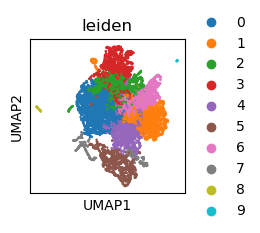

/Users/yakir/Dropbox/py/cna/src/cna/tools/_stats.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Yg = np.array([Y[G==g][0] for g in Gu])


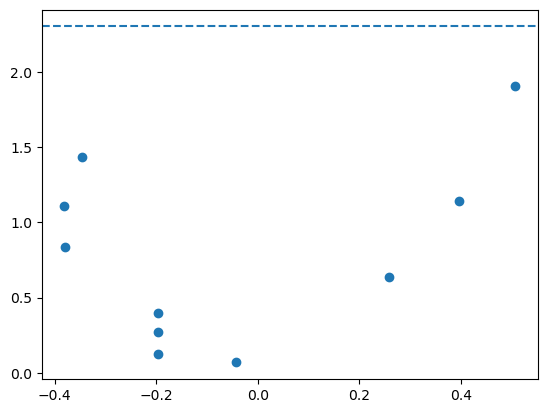

In [77]:
from scipy.stats import ttest_ind
d = cna.read(f'_results/patchwideavgs.h5ad'); d.sampleid = 'sid'
plt.figure(figsize=(2,2)); sc.pl.umap(d, color='leiden', ax=plt.gca())
ct = pd.crosstab(d.obs.sid, d.obs.leiden)
ct = ct.div(ct.sum(axis=1), axis=0)
clusts = ct.columns.values
ct['donor'] = d.samplem.donor
ct['fstar'] = d.samplem.fstar
    
fdrs, stats, ps = test_clusters(ct, clusts, 'fstar', 'donor')
plt.scatter(stats, -np.log10(ps))
plt.axhline(-np.log10(0.05/len(ps)), ls='--')
plt.show()
pd.DataFrame(data={'p':ps, 'stat':stats}, index=pd.Series(d.obs.leiden.unique(), name='cluster')
            ).to_csv('_results/patchwideavgs_clustertest.csv')

## Patchwide averages -> microniche analysis

In [9]:
Ddense_avg = cna.read(f'_results/patchwideavgs.h5ad'); Ddense_avg.sampleid = 'sid'
res = va.association(Ddense_avg, Ddense_avg.samplem.fstar)
Ddense_avg.write(f'_results/patchwideavgs.h5ad')

P = 0.004209957900420996, used 3 MAM-PCs
No microniches found at FDR 10%


## Patch fingerprints -> cluster

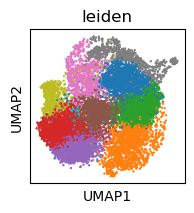

/Users/yakir/Dropbox/py/cna/src/cna/tools/_stats.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Yg = np.array([Y[G==g][0] for g in Gu])


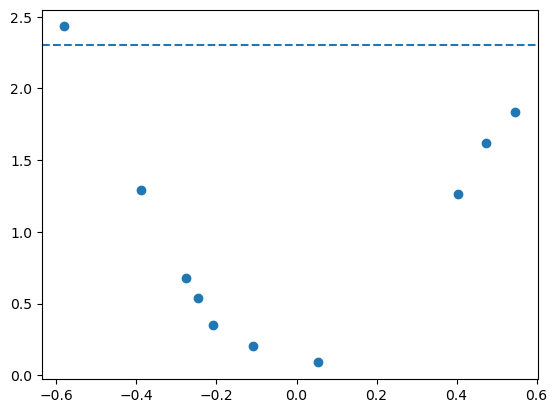

In [45]:
from scipy.stats import ttest_ind
d = cna.read(f'_results/default-vae.h5ad'); d.sampleid = 'sid'
plt.figure(figsize=(2,2)); sc.pl.umap(d, color='leiden', legend_loc=None, ax=plt.gca())
ct = pd.crosstab(d.obs.sid, d.obs.leiden)
ct = ct.div(ct.sum(axis=1), axis=0)
clusts = ct.columns.values
ct['donor'] = d.samplem.donor
ct['fstar'] = d.samplem.fstar
    
fdrs, stats, ps = test_clusters(ct, clusts, 'fstar', 'donor')
plt.scatter(stats, -np.log10(ps))
plt.axhline(-np.log10(0.05/len(ps)), ls='--')
plt.show()
pd.DataFrame(data={'p':ps, 'stat':stats}, index=pd.Series(d.obs.leiden.unique(), name='cluster')
            ).to_csv('_results/patchfingerprints_clustertest.csv')

In [43]:
ps[ps <= 0.05/len(ps)], clusts[ps <= 0.05/len(ps)], (d.obs['leiden'] == '1').sum()

(array([0.00319968]),
 ['1']
 Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9'],
 1448)

## VIMA (patch fingerprints -> microniche analysis)

In [10]:
Ddense = cna.read(f'_results/default-vae.h5ad'); Ddense.sampleid = 'sid'
res = va.association(Ddense, Ddense.samplem.fstar)

P = 0.0006599934000659993, used 2 MAM-PCs
Found 3669.0 microniches at FDR 10%


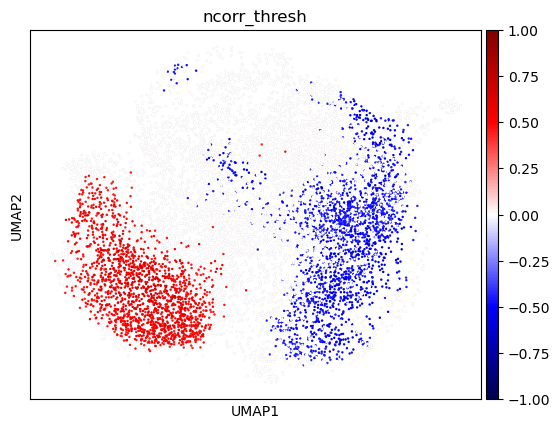

In [11]:
sc.pl.umap(Ddense, ax=plt.gca(), show=False)
sc.pl.umap(Ddense, color='sig_mncoeff', cmap='seismic', vmin=-1, vmax=1, ax=plt.gca())

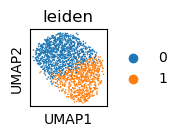

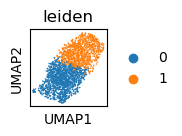

In [11]:
sig_pos = Ddense[Ddense.obs.sig_mncoeff > 0].copy()
sig_neg = Ddense[Ddense.obs.sig_mncoeff < 0].copy()
for label, d_sig, r in [('pos', sig_pos, 0.35), ('neg', sig_neg, 0.2)]:
    np.random.seed(0)
    sc.pp.neighbors(d_sig, use_rep='X')
    sc.tl.umap(d_sig)
    sc.tl.leiden(d_sig, resolution=r, key_added='leiden', seed=0)
    plt.figure(figsize=(1,1)); sc.pl.umap(d_sig, color='leiden', s=5, ax=plt.gca())
    Ddense.obs[label+'_leiden'] = d_sig.obs.leiden

# count number of patches of each type per sample
Ddense.samplem['npatches'] = Ddense.obs.sid.value_counts()
Ddense.samplem[['nneg', 'npos']] = pd.crosstab(Ddense.obs.sid, Ddense.obs.sig_mncoeff.map(
                                    lambda x: 0 if x < 0 else (1 if x > 0 else np.nan)
                                ))
Ddense.samplem.drop(columns=[c for c in Ddense.samplem.columns if c.startswith('pos') or c.startswith('neg')], inplace=True)
Ddense.samplem[[f'pos{c}' for c in Ddense.obs.pos_leiden.unique() if c == c]] = pd.crosstab(Ddense.obs.sid, Ddense.obs.pos_leiden)
Ddense.samplem[[f'neg{c}' for c in Ddense.obs.neg_leiden.unique() if c == c]] = pd.crosstab(Ddense.obs.sid, Ddense.obs.neg_leiden)
Ddense.samplem = Ddense.samplem.fillna(0)

Ddense.write(f'_results/{name}-vae.h5ad')